In [112]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [113]:
data = yf.download('0700.hk')
# data.drop("Adj Close",axis=1,inplace=True)
data.head(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-16,0.875,0.925,0.815,0.830,0.802119,2198875000
2004-06-17,0.830,0.875,0.825,0.845,0.816615,419007500
2004-06-18,0.840,0.850,0.790,0.805,0.777959,182990000
2004-06-21,0.820,0.825,0.790,0.800,0.773127,114085000
2004-06-22,0.800,0.800,0.800,0.800,0.773127,0
2004-06-23,0.810,0.890,0.805,0.885,0.855272,275080000
2004-06-24,0.895,0.905,0.865,0.890,0.860104,173615000
2004-06-25,0.895,0.910,0.870,0.880,0.850440,106062500
2004-06-28,0.880,0.880,0.850,0.865,0.835943,73730000


In [114]:
scaler=MinMaxScaler(feature_range=(-1,1))
df = data
df['6day MA'] = df['Close'].rolling(window = 6).mean()
df['12day MA'] = df['Close'].rolling(window = 12).mean()
df['RSI'] = talib.RSI(df['Close'].values, timeperiod = 7)
df['%R5'] = talib.WILLR(df['High'].values, df['Low'].values, df['Close'].values, 5)
df['%R10'] = talib.WILLR(df['High'].values, df['Low'].values, df['Close'].values, 10)
df['MTM6']=talib.MOM(df['Close'],timeperiod=6)
df['MTM12']=talib.MOM(df['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['EMA12']=talib.EMA(df['Close'], timeperiod=12)
df['EMA26']=talib.EMA(df['Close'],timeperiod=26)
df['MACD']=macd
df['TR']=talib.TRANGE(df['High'],df['Low'],df['Close'])
df['OSC6']=talib.CMO(df['Close'], timeperiod=6)
df['OSC12']=talib.CMO(df['Close'], timeperiod=12)
#Create one more column Prediction shifted 15 days up. 
df['Prediction'] = data[['Close']].shift(-1)
#print data set
df=df.dropna()
print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-08-02    0.770000    0.775000    0.740000    0.775000    0.748967   
2004-08-03    0.780000    0.795000    0.775000    0.790000    0.763463   
2004-08-04    0.780000    0.785000    0.765000    0.770000    0.744135   
2004-08-05    0.780000    0.805000    0.780000    0.795000    0.768295   
2004-08-06    0.785000    0.810000    0.785000    0.800000    0.773127   
...                ...         ...         ...         ...         ...   
2021-12-24  460.799988  460.799988  460.799988  460.799988  460.799988   
2021-12-28  457.799988  459.200012  445.000000  450.399994  450.399994   
2021-12-29  443.600006  445.600006  440.399994  444.799988  444.799988   
2021-12-30  446.399994  450.799988  442.000000  443.399994  443.399994   
2021-12-31  458.000000  458.000000  458.000000  458.000000  458.000000   

              Volume     6day MA    1

In [115]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(SVR(),k_features=(1,19),forward=False,verbose=2,cv=0,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(df.drop('Prediction',1)),df['Prediction'].values.ravel())

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_54606/2748608415.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  backwardModel.fit(np.array(df.drop('Prediction',1)),df['Prediction'].values.ravel())
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    4.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.5s finished

[2022-01-04 01:32:07] Features: 18/1 -- score: 0.9711249078231186[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    3.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.5s finished

[2022-01-04 01:32:11] Features: 17/1 -- score: 0.9714801787506613[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out

SequentialFeatureSelector(cv=0, estimator=SVR(), forward=False,
                          k_features=(1, 19), n_jobs=-1, scoring='r2',
                          verbose=2)

In [116]:
df.columns[list(backwardModel.k_feature_idx_)]

Index(['Low', '%R5', 'EMA26', 'MACD', 'TR'], dtype='object')

In [117]:
#Create a data set X and convert it into numpy array , which will be having actual values
X = np.array(df[df.columns[list(backwardModel.k_feature_idx_)]])
# X=scaler.fit_transform(X)
#Remove the last 15 rows
x_unseen=X[-100:]
X=X[:-100]
print(X.shape)
# Create a dataset y which will be having Predicted values and convert into numpy array
y = np.array(df['Prediction']).reshape(-1,1)
# y=scaler_y.fit_transform(y)
# Remove Last 15 rows
y_unseen=y[-100:]
y=y[:-100]
print(y.shape)

(4206, 5)
(4206, 1)


In [118]:
# Split the data into train and test with 90 & 10 % respectively
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [119]:
# SVM Model
svr = make_pipeline(MinMaxScaler(feature_range=(-1,1)),SVR())
# Train the model 
svr.fit(x_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/FYP/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('minmaxscaler', MinMaxScaler(feature_range=(-1, 1))),
                ('svr', SVR())])

In [120]:
# The best possible score is 1.0
svm_confidence = svr.score(x_test, y_test)
print("svm confidence: ", svm_confidence)

svm confidence:  -6.722922169188519


In [121]:
y_pred=svr.predict(x_test).reshape(-1,1)
# y_pred=scaler_y.inverse_transform(y_pred)
# y_test=scaler_y.inverse_transform(y_test)

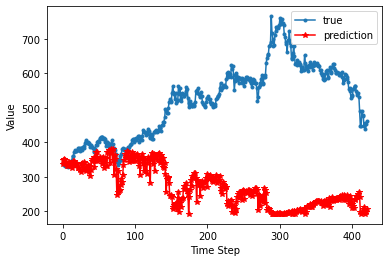

In [122]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [123]:
mean_squared_error(y_test,y_pred,squared=False)

294.4277633263077

In [124]:
mean_absolute_percentage_error(y_test,y_pred)

0.4344949727105439

In [125]:
r2_score(y_test,y_pred)

-6.722922169188519

# Unseen Data

In [126]:
svm_prediction = svr.predict(x_unseen)
# svm_prediction=scaler_y.inverse_transform(svm_prediction.reshape(-1,1))
# y_unseen=scaler_y.inverse_transform(y_unseen.reshape(-1,1))

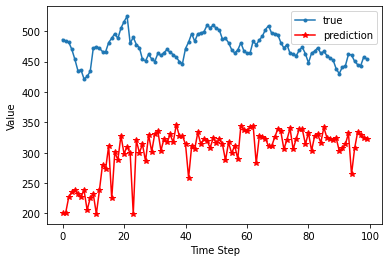

In [127]:
plt.plot(y_unseen, marker='.', label="true")
plt.plot(svm_prediction, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [128]:
r2_score(y_unseen,svm_prediction)

-67.1583682024021

In [129]:
mean_squared_error(y_unseen,svm_prediction,squared=False)

173.90605642645752

In [130]:
mean_absolute_percentage_error(y_unseen,svm_prediction)

0.357575797538044